In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./competition.ipynb
./sample_submission.csv
./test.csv
./train.csv


In [39]:
tracksDf = pd.read_csv('./train.csv')
testTracksDf = pd.read_csv('./test.csv')

# Identificação de informações importantes do DataFrame
tracksDf.head()
testTracksDf.describe()

,track_unique_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,34200.000000,3.420000e+04,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000,34200.000000
mean,56670.513889,2.283254e+05,0.565591,0.641041,5.314035,-8.247806,0.637135,0.084423,0.314750,0.153087,0.214113,0.473605,122.314152,3.907485
std,32710.184506,1.123471e+05,0.174544,0.251737,3.554899,5.014973,0.480834,0.105910,0.332552,0.306634,0.191084,0.259849,30.062414,0.428702
min,3.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28612.500000,1.733250e+05,0.455000,0.472000,2.000000,-10.039000,0.000000,0.035800,0.016600,0.000000,0.098200,0.256000,99.537500,4.000000
50%,56475.500000,2.131775e+05,0.579000,0.683000,5.000000,-6.984000,1.000000,0.048700,0.168500,0.000043,0.133000,0.463000,122.052500,4.000000
75%,84855.750000,2.616720e+05,0.693000,0.853000,8.000000,-5.011000,1.000000,0.084700,0.597000,0.045800,0.273000,0.682000,140.204000,4.000000
max,113999.000000,4.730302e+06,0.980000,1.000000,11.000000,1.795000,1.000000,0.963000,0.996000,1.000000,1.000000,0.992000,243.372000,5.000000


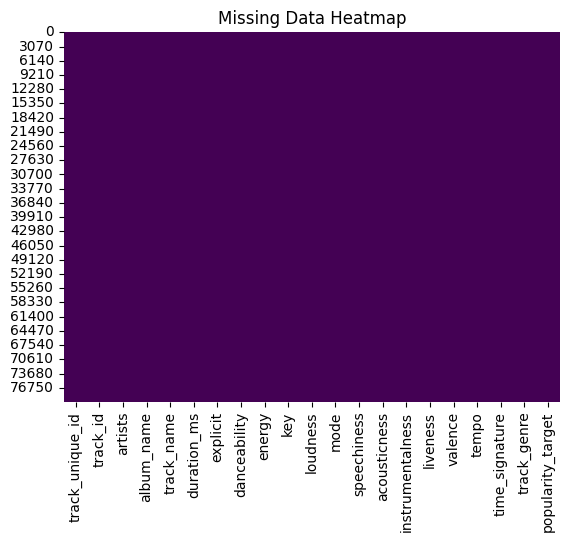

In [40]:
## Mapa de Calor dos possiveis valores nulos
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(tracksDf.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

In [41]:
## Encoding das Features Categóricas: Aqui estamos fazendo o Encoding para ambos os CSVs, o de treino e o de teste

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
import numpy as np

# Cópia do DataFrame original
df_encoded = tracksDf.copy()
test_df_encoded = testTracksDf.copy()

# Encoding binário para as features 'explicit' e 'mode' (Já estão no formato binário no DataFrame original)
df_encoded['explicit'] = df_encoded['explicit'].astype(int)
df_encoded['mode'] = df_encoded['mode'].astype(int)

test_df_encoded['explicit'] = test_df_encoded['explicit'].astype(int)
test_df_encoded['mode'] = test_df_encoded['mode'].astype(int)


# Ordinal Encoding para as features 'key' e 'time_signature'- Razão: 
ordinal_encoder = OrdinalEncoder()
df_encoded[['key', 'time_signature']] = ordinal_encoder.fit_transform(df_encoded[['key', 'time_signature']])
test_df_encoded[['key', 'time_signature']] = ordinal_encoder.transform(test_df_encoded[['key', 'time_signature']])


# Ecoding de Frequência para as features 'artists', 'album_name', 'track_name' e 'track_genre' - Razão: 
for col in ['artists', 'album_name', 'track_name', 'track_genre']:
    freq_encoding = df_encoded[col].value_counts(normalize=True).to_dict()
    df_encoded[col] = df_encoded[col].map(freq_encoding)
    test_df_encoded[col] = test_df_encoded[col].map(freq_encoding)

# Standard Scaling pras features numéricas contínuas
scaler = StandardScaler()
df_encoded[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] = scaler.fit_transform(
            df_encoded[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 
                        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']])
test_df_encoded[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']] = scaler.transform(
                    test_df_encoded[['duration_ms', 'danceability', 'energy', 'loudness', 'speechiness',
                                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']])

df_encoded.head()

,track_unique_id,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_target
0,41996,7hUhmkALyQ8SX9mJs5XI3D,0.000013,0.000013,0.000013,-0.155809,0,-1.515338,0.825132,9.0,...,1,-0.282524,-0.947099,-0.323754,1.318896,-0.595605,0.658493,3.0,0.008421,0
1,76471,5x59U89ZnjZXuNAAlc8X1u,0.000088,0.000025,0.000013,-0.303659,0,-1.619319,-1.795774,7.0,...,0,-0.451941,1.849631,-0.505047,-0.683485,-1.317590,-1.282208,3.0,0.008897,0
2,54809,70Vng5jLzoJLmeLu3ayBQq,0.000213,0.000025,0.000013,-0.108474,0,0.090590,-0.527081,1.0,...,1,-0.459513,1.389495,0.143765,-0.517234,0.269232,-1.055969,2.0,0.008246,1
3,16326,1cRfzLJapgtwJ61xszs37b,0.000013,0.000338,0.000013,-0.090960,0,-2.335633,-2.405065,8.0,...,1,-0.355402,2.033084,2.386439,-0.559323,-1.681671,-1.757899,2.0,0.008747,0
4,109799,47d5lYjbiMy0EdMRV8lRou,0.001466,0.000150,0.000038,-0.521060,0,0.460300,1.111483,2.0,...,1,0.948829,-0.944450,0.687541,-0.433056,-1.170877,0.531179,3.0,0.008747,0


In [42]:
## Aqui prosseguimos com o Encoding das Features Categóricas: Também para ambos os CSVs, o de treino e o de teste

# Exclui features que são identificadores únicos 'track_id', porque não vão contribuir para a análise de tendências/padrões pelos futuros modelos
df_encoded_refined = df_encoded.drop(columns=['track_id']) # Não dropamos a feature track_unique_id, pois ela é necessária para a submissão
test_df_encoded_refined = test_df_encoded.drop(columns=['track_id'])

## Target Encoding para as features 'artists', 'album_name', 'track_name', 'track_genre' baseado na feature 'popularity_target'
from sklearn.model_selection import KFold

# Função pra facilitar o Target Encoding 
def target_encode(df, col, target, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    df[col + '_target_enc'] = np.nan
    for train_idx, val_idx in kf.split(df):
        train, val = df.iloc[train_idx], df.iloc[val_idx]
        means = train.groupby(col)[target].mean()
        df.loc[df.index[val_idx], col + '_target_enc'] = df[col].map(means)
    # Preenche qualquer NaN que resulte de novas categorias nos folds de validação
    df[col + '_target_enc'].fillna(df[target].mean(), inplace=True)
    return df


# Aplica o Target Encoding para as features 'artists', 'album_name', 'track_name' e 'track_genre': (Não aplicamos ao CSV de teste, pois não possui o popularity_target)
for col in ['artists', 'album_name', 'track_name', 'track_genre']:
    df_encoded_refined = target_encode(df_encoded_refined, col, 'popularity_target')
    df_encoded_refined.drop(columns=[col], inplace=True)  # Dropa a coluna categórica original


# Verifying the first few rows of the refined dataset
df_encoded_refined.head()



,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target,artists_target_enc,album_name_target_enc,track_name_target_enc,track_genre_target_enc
0,41996,-0.155809,0,-1.515338,0.825132,9.0,-0.502686,1,-0.282524,-0.947099,-0.323754,1.318896,-0.595605,0.658493,3.0,0,0.556716,0.561155,0.461534,0.190654
1,76471,-0.303659,0,-1.619319,-1.795774,7.0,-0.747946,0,-0.451941,1.849631,-0.505047,-0.683485,-1.317590,-1.282208,3.0,0,0.469266,0.624453,0.462779,0.210557
2,54809,-0.108474,0,0.090590,-0.527081,1.0,-0.277483,1,-0.459513,1.389495,0.143765,-0.517234,0.269232,-1.055969,2.0,1,0.458543,0.622265,0.463722,0.093458
3,16326,-0.090960,0,-2.335633,-2.405065,8.0,-2.956080,1,-0.355402,2.033084,2.386439,-0.559323,-1.681671,-1.757899,2.0,0,0.552362,0.088561,0.462779,0.494620
4,109799,-0.521060,0,0.460300,1.111483,2.0,0.192582,1,0.948829,-0.944450,0.687541,-0.433056,-1.170877,0.531179,3.0,0,0.109890,0.558422,0.617690,0.495690


In [43]:
df_encoded_refined.describe()

,track_unique_id,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity_target,artists_target_enc,album_name_target_enc,track_name_target_enc,track_genre_target_enc
count,79800.000000,7.980000e+04,79800.000000,7.980000e+04,7.980000e+04,79800.000000,7.980000e+04,79800.000000,7.980000e+04,7.980000e+04,7.980000e+04,7.980000e+04,7.980000e+04,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,57140.494048,1.182457e-16,0.085689,-2.768713e-16,3.661343e-16,5.307043,-8.619115e-17,0.637732,9.865681e-17,2.760254e-16,-6.865018e-17,7.287960e-17,9.046509e-17,-1.113006e-17,2.912732,0.487845,0.487832,0.487863,0.487828,0.487852
std,32993.196225,1.000006e+00,0.279906,1.000006e+00,1.000006e+00,3.562186,1.000006e+00,0.480659,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.370199,0.499855,0.123128,0.183587,0.120725,0.199457
min,0.000000,-2.041860e+00,0.000000,-3.277238e+00,-2.551345e+00,0.000000,-8.150826e+00,0.000000,-8.021340e-01,-9.472744e-01,-5.061923e-01,-1.122262e+00,-1.831087e+00,-4.077135e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.011257
25%,28450.500000,-5.089148e-01,0.000000,-6.430537e-01,-6.742334e-01,2.000000,-3.459972e-01,0.000000,-4.623526e-01,-8.961481e-01,-5.061923e-01,-6.071988e-01,-8.233973e-01,-7.680015e-01,3.000000,0.000000,0.451923,0.499502,0.461801,0.377425
50%,57234.000000,-1.436256e-01,0.000000,7.903627e-02,1.728880e-01,5.000000,2.485846e-01,1.000000,-3.383654e-01,-4.390195e-01,-5.060607e-01,-4.277948e-01,-3.963863e-02,-2.256363e-03,3.000000,0.000000,0.498834,0.561527,0.463231,0.467195
75%,85774.250000,3.190944e-01,0.000000,7.375824e-01,8.450171e-01,8.000000,6.481499e-01,1.000000,-2.369808e-03,8.511661e-01,-3.437030e-01,3.140226e-01,8.097550e-01,6.004138e-01,3.000000,1.000000,0.554341,0.578905,0.616364,0.577723
max,113998.000000,4.768161e+01,1.000000,2.412831e+00,1.425673e+00,11.000000,2.541120e+00,1.000000,8.331268e+00,2.048121e+00,2.711418e+00,4.138854e+00,2.010489e+00,3.357467e+00,4.000000,1.000000,1.000000,1.000000,0.645405,0.964789


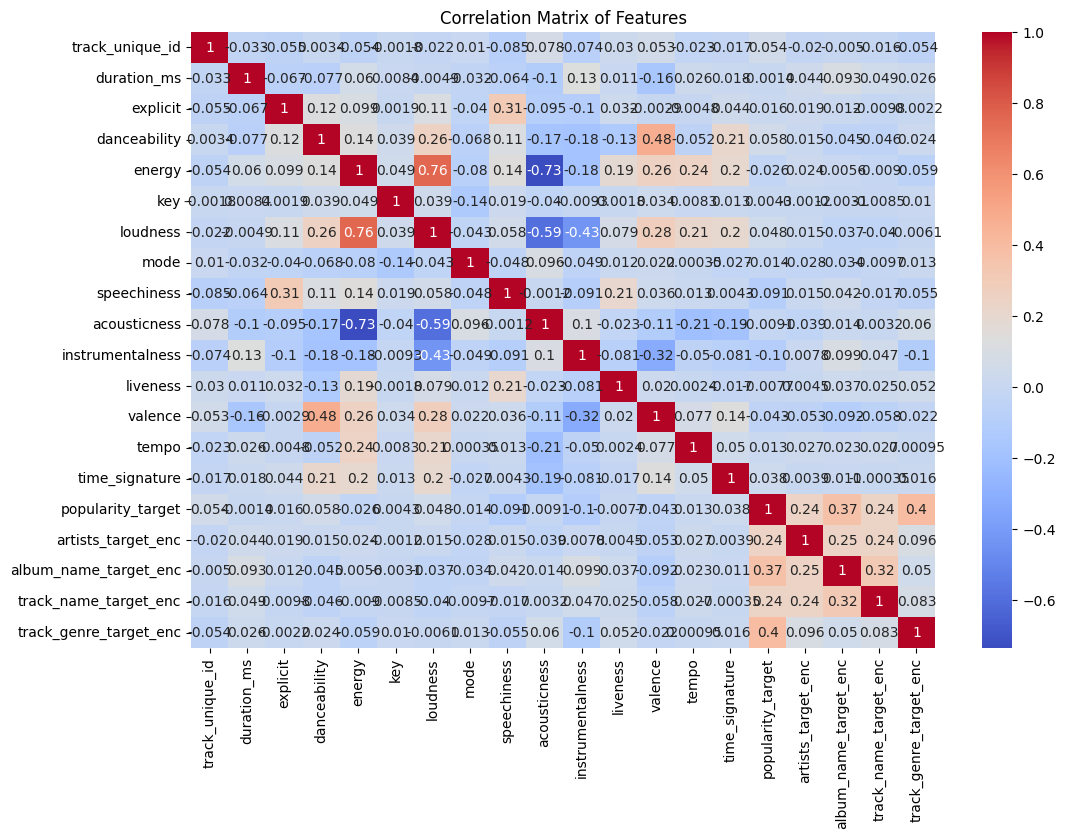

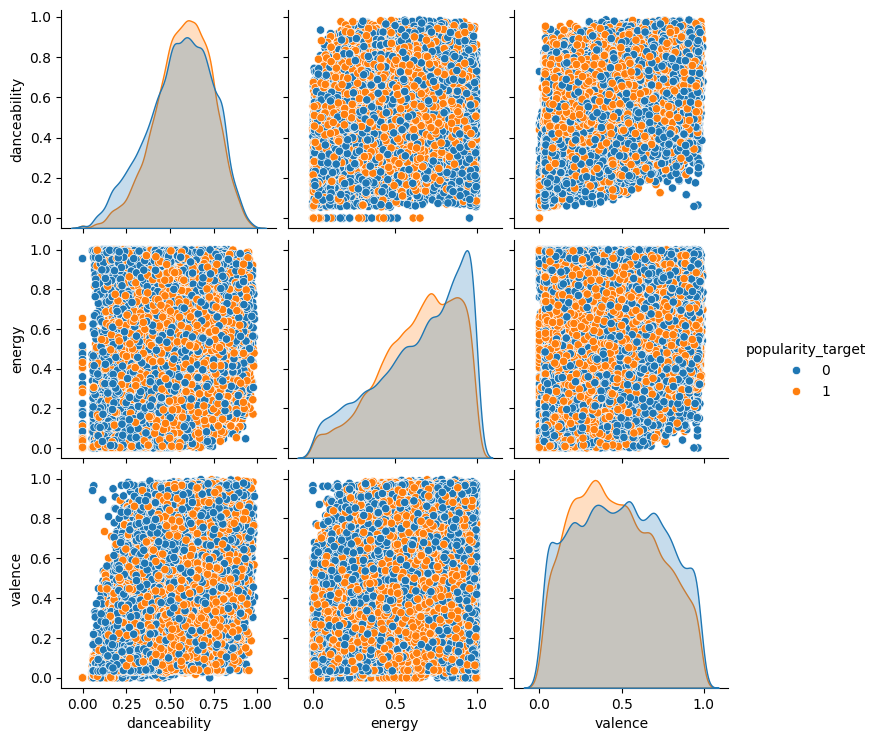

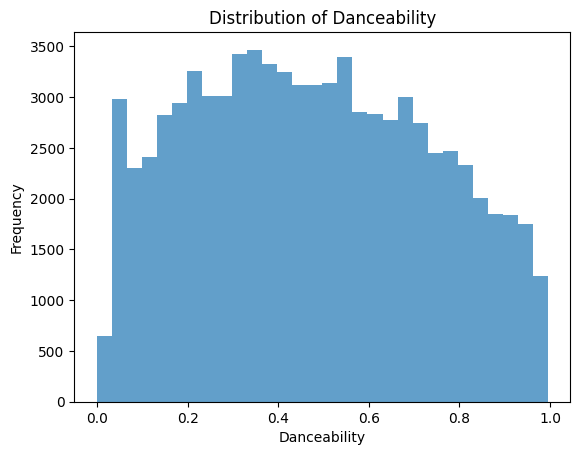

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

## Matriz de correlação
correlation_matrix = df_encoded_refined.corr()

# Plota o mapa de calor da correlação
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()

# Plota o Pair Plot que nos mostra a relação entre as features 'popularity_target' e 'danceability', 'energy', 'valence'  e 'popularity_target'
key_features = ['danceability', 'energy', 'valence', 'popularity_target']
sns.pairplot(tracksDf[key_features], hue='popularity_target')
plt.show()

tracksDf['valence'].plot(kind='hist', bins=30, alpha=0.7)
plt.title('Distribution of Danceability')
plt.xlabel('Danceability')
plt.show()

# Definição das Features mais importantes

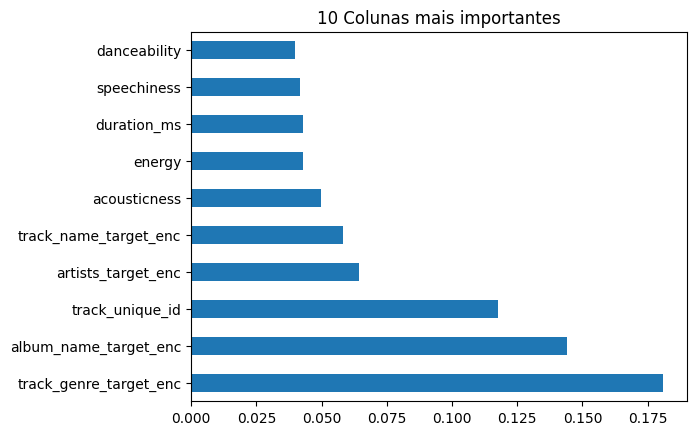

In [45]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Treina um modelo de Random Forest para identificar as colunas mais importantes
X = df_encoded_refined.drop('popularity_target', axis=1)
y = df_encoded_refined['popularity_target']
model = RandomForestClassifier()
model.fit(X, y)

# Plota as 10 colunas mais importantes
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('10 Colunas mais importantes')
plt.show()


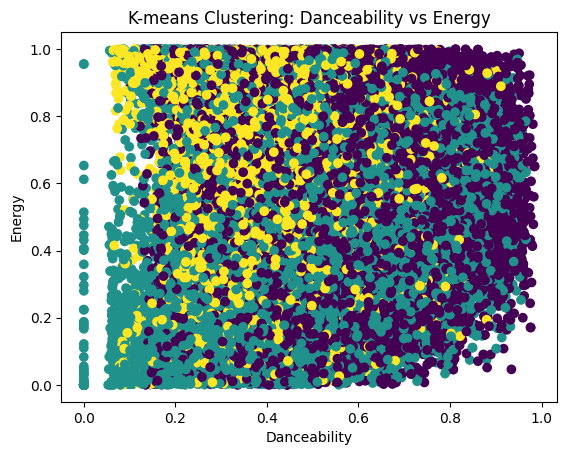

In [46]:
# Roda o K-means clustering para as colunas 'danceability', 'energy', 'valence' e 'tempo', com 3 clusters
from sklearn.cluster import KMeans
X = tracksDf[['danceability', 'energy', 'valence', 'tempo']]

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

plt.scatter(X['danceability'], X['energy'], c=clusters, cmap='viridis')
plt.title('K-means Clustering: Danceability vs Energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.show()



# Formulação de Hipóteses

### Hipótese 1: Músicas com valores de Energy e Danceability mais altos são mais populares
- Razão: Na análise de feature importance, apesar de Energy e Danceability não estarem elencadas como features mais importantes, é um senso comum que músicas mais animadas e dançantes tendem a gerar mais engajamento em plataformas de streaming e até aparecerem mais em trends de redes sociais, o que é um fator que, especialmente na última década, tem sido um fator muito determinante para o sucesso de uma música. Portanto, queremos testar se essa hipótese é verdadeira.

### Hipótese 2: Músicas de um Genero específico são mais populares
- Razão: A análise de feature importance mostrou que a feature Genre é a mais determinante para a popularidade de uma música. Portanto, queremos testar se essa hipótese é verdadeira.

### Hipótese 3: Músicas de artistas específicos são mais populares
- Razão: A análise de feature importance mostrou que a feature Artist é a terceira mais determinante para a popularidade de uma música, atrás somente do Álbum e do Gênero. Portanto, queremos testar se essa hipótese é verdadeira.

### Teste da Hipótese 1: Músicas com valores de Energy e Danceability mais altos são mais populares

C:\Users\Caleb\AppData\Local\Temp\ipykernel_9320\408129790.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='popularity_target', y='danceability', data=df, ax=axes[0], palette="Blues", )
C:\Users\Caleb\AppData\Local\Temp\ipykernel_9320\408129790.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='popularity_target', y='energy', data=df, ax=axes[1], palette="Reds")


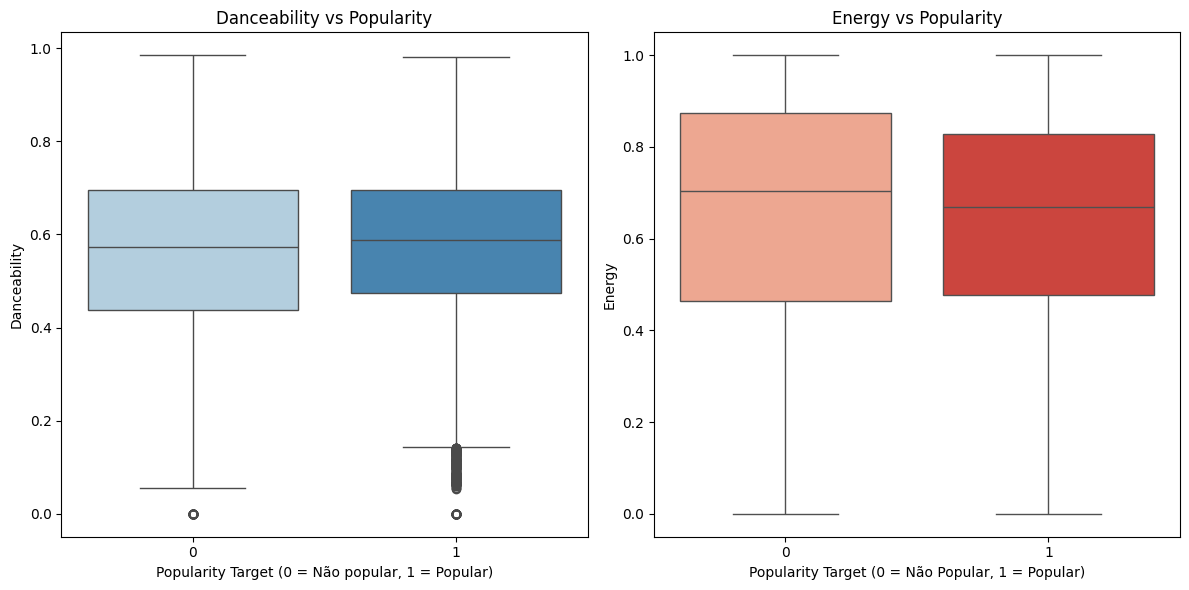

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = tracksDf

# Teste de Hipótese 1: Danceability e Energy vs Popularity

# Group by popularity_target e calcula a média de danceability e energy para cada grupo
popularity_vs_dance_energy = df.groupby('popularity_target')[['danceability', 'energy']].mean()

# Visualizando a correlação entre danceability e energy com a popularidade
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Danceability vs Popularity
sns.boxplot(x='popularity_target', y='danceability', data=df, ax=axes[0], palette="Blues", )
axes[0].set_title('Danceability vs Popularity')
axes[0].set_xlabel('Popularity Target (0 = Não popular, 1 = Popular)')
axes[0].set_ylabel('Danceability')

# Energy vs Popularity
sns.boxplot(x='popularity_target', y='energy', data=df, ax=axes[1], palette="Reds")
axes[1].set_title('Energy vs Popularity')
axes[1].set_xlabel('Popularity Target (0 = Não Popular, 1 = Popular)')
axes[1].set_ylabel('Energy')

plt.tight_layout()
plt.show()



#### Conclusão do Teste da Hipótese 1: A hipótese 1 não foi confirmada.
- Evidências: A mediana de Energy e Danceability das músicas mais populares é muito similar à mediana das músicas menos populares, com a mediana de Energy das músicas mais populares sendo inferior à das menos populares. Além disso, o boxplot, que revela o quartil 1 e 3, mostra que a dispersão dos valores de Energy e Danceability das músicas mais populares é também muito similar à das músicas menos populares. Portanto, não há evidências de que músicas com valores de Energy e Danceability mais altos são mais populares.

### Teste da Hipótese 2: Músicas de um Gênero específico são mais populares

In [48]:
# Agrupa os dados por gênero e calcula a média da popularidade para cada gênero
genre_popularity = df.groupby('track_genre')['popularity_target'].mean().reset_index()

# Ordena os gêneros pela popularidade média
genre_popularity = genre_popularity.sort_values(by='popularity_target', ascending=False)

print(genre_popularity)


        track_genre  popularity_target
35            forro           1.000000
97        sertanejo           0.998540
40           gospel           0.990113
112         turkish           0.970381
55           indian           0.964589
..              ...                ...
24   detroit-techno           0.039886
42        grindcore           0.015015
108           tango           0.005764
93          romance           0.000000
59          iranian           0.000000

[114 rows x 2 columns]


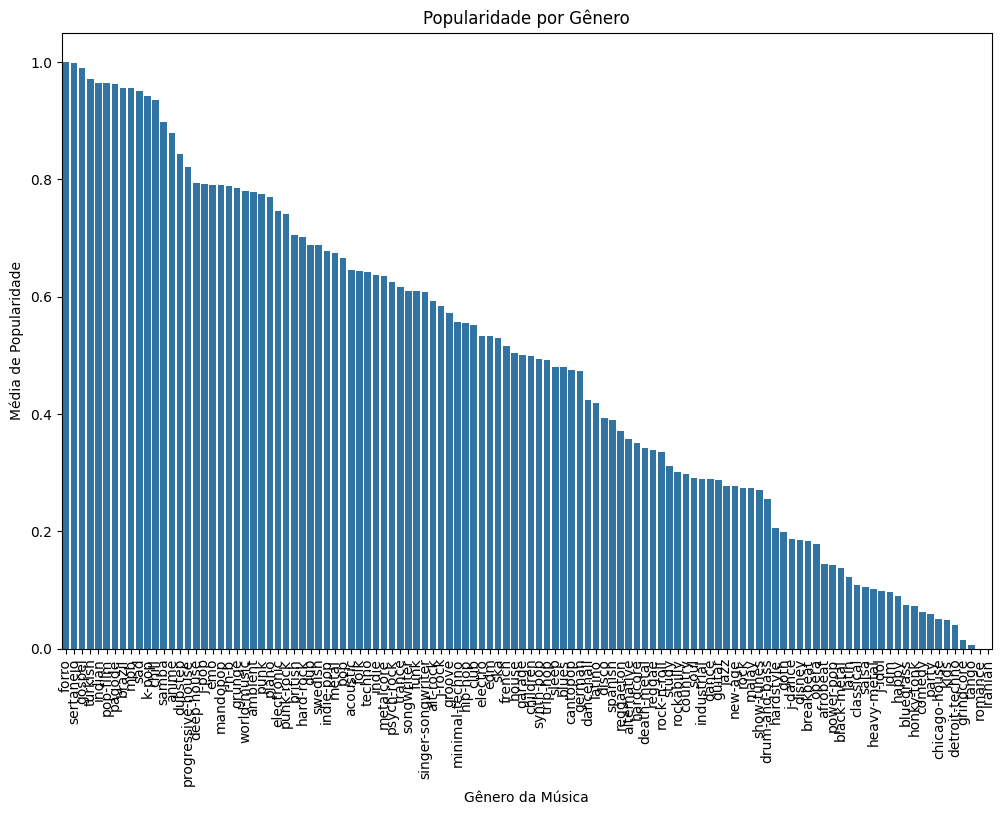

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a bar chart to visualize the popularity of each genre
plt.figure(figsize=(12, 8))
sns.barplot(x='track_genre', y='popularity_target', data=genre_popularity)
plt.xticks(rotation=90)
plt.title('Popularidade por Gênero')
plt.xlabel('Gênero da Música')
plt.ylabel('Média de Popularidade')
plt.show()


In [50]:
from scipy.stats import chi2_contingency

# Create a contingency table of genres and popularity
contingency_table = pd.crosstab(df['track_genre'], df['popularity_target'])

# Perform Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the test results
print(f"Teste do Qui-quadrado {chi2}")
print(f"P-Value: {p_value}")

# Conclusion
if p_value < 0.05:
    print("Existem evidências de uma associação significativa entre gênero e popularidade.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula.")


Teste do Qui-quadrado 27165.357243548722
P-Value: 0.0
Existem evidências de uma associação significativa entre gênero e popularidade.


#### Conclusão do Teste da Hipótese 2: Músicas de um Genero específico são mais populares
- Evidência: forro, sertanejo, gospel, turkish e indian apresentam médias de popularidade substancialmente mais elevadas que os demais gêneros.

### Teste da Hipótese 3: Músicas de artistas específicos são mais populares

In [51]:
# Agrupa os dados por artistas e calcula a média da popularidade para cada artista
artist_popularity = df.groupby('artists')['popularity_target'].mean().reset_index()
# Find the mean popularity of all artists
artist_popularity['popularity_target'] = artist_popularity['popularity_target'] * 100
print("Popularidade média de todos os artistas: {:.2f}%".format(artist_popularity['popularity_target'].mean()))
# Find the number of artists with popularity of 100%
num_artists_100 = artist_popularity[artist_popularity['popularity_target'] == 100].shape[0]
print("Número de artistas com popularidade de 100%: {}".format(num_artists_100))
# Find number of artists
print("Número total de artistas: {}".format(len(artist_popularity)))

# Ordena os artistas pela popularidade média
artist_popularity = artist_popularity.sort_values(by='popularity_target', ascending=False)

# Display the results
print(artist_popularity)


Popularidade média de todos os artistas: 54.18%
Número de artistas com popularidade de 100%: 12830
Número total de artistas: 25775
                                        artists  popularity_target
20507                             Shubham Kabra              100.0
9648                      Hogland;Charlie South              100.0
18879                                  Rita Ora              100.0
18878                     Rita Lee;Zélia Duncan              100.0
9639                                Hiérophante              100.0
...                                         ...                ...
18669           Reiki Armonía;Sleep;White Noise                0.0
18670  Reiki Armonía;Solfeggio;Relajación Piano                0.0
9936                             IWaata;Intence                0.0
9935                                     IWaata                0.0
25774                                   龍藏Ryuzo                0.0

[25775 rows x 2 columns]


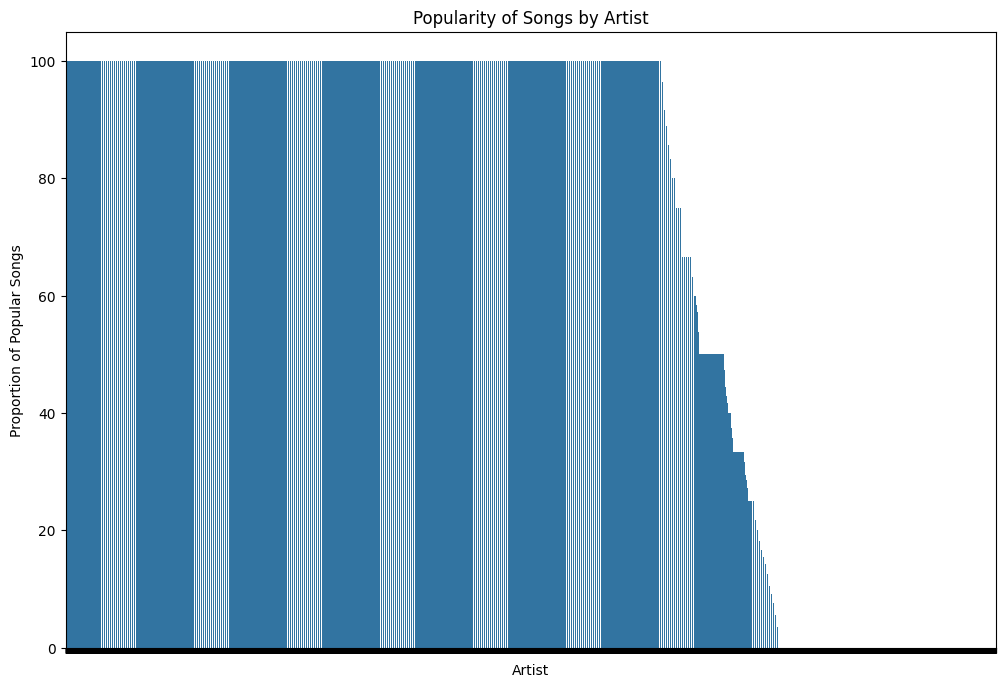

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a bar chart to visualize the popularity of each artist without showing their names
plt.figure(figsize=(12, 8))
top_artists = artist_popularity.head(20000)  # Select top 20 artists for readability
sns.barplot(x='artists', y='popularity_target', data=top_artists)

# Remove the artist names by setting the x-tick labels to empty strings
plt.xticks(ticks=range(len(top_artists)), labels=['']*len(top_artists))

plt.title('Popularity of Songs by Artist')
plt.xlabel('Artist')
plt.ylabel('Proportion of Popular Songs')
plt.show()


In [53]:
from scipy.stats import chi2_contingency

# Create a contingency table of artists and popularity
contingency_table = pd.crosstab(df['artists'], df['popularity_target'])

# Perform Chi-Square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the test results
print(f"Qui-Quadrado: {chi2}")
print(f"P-Value: {p_value}")

# Conclusion
if p_value < 0.05:
    print("Existem evidências de uma associação significativa entre artista e popularidade.")
else:
    print("Não há evidências suficientes para rejeitar a hipótese nula.")


Qui-Quadrado: 62670.580401571504
P-Value: 0.0
Existem evidências de uma associação significativa entre artista e popularidade.


### Conclusão: Hipótese foi confirmada
- Evidência: Aqui temos um fenômeno estranho no qual observamos que, dos 25.775 artistas presentes no CSV, exatamente 12.830 têm 100% de suas músicas presentes no CSV apresentando a feature de popularity igual a 1. Isso faz com que o artista ao qual a música pertence tenha uma relevância muito alta para predizer o target de popularity.
- Chegamos à conclusão que músicas dos 12.830 artistas mais populares têm 100% de chance de serem populares, portanto, a hipótese foi confirmada. 

# Seleção de Features

In [54]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Cria o modelo de Regressão Logística
model = LogisticRegression()

# Aplica o RFE ()
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X, y)

# Printa as features selecionadas
selected_features = X.columns[fit.support_]
print(f'Features selecionadas: {selected_features}')


Features selecionadas: Index(['danceability', 'energy', 'valence', 'tempo'], dtype='object')


# Construção dos Modelos

In [55]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#  Divide o DataFrame em features (X) e target (y)
X = df_encoded_refined.drop(columns=['popularity_target'])
y = df_encoded_refined['popularity_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplica o StandardScaler para padronizar as features, exceto a variável target
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define os modelos de classificação
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB()
}

# Dicionário para armazenar as métricas de avaliação
evaluation_metrics = {}

# Treina e avalia os modelos
for model_name, model in models.items():
    # Treina o modelo
    model.fit(X_train_scaled, y_train)
    
    # Faz as predições
    y_pred = model.predict(X_test_scaled)
    
    # Calcula as métricas de avaliação (accuracy, precision, recall, f1-score)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Armazena as métricas de avaliação no dicionário
    evaluation_metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Exibe os resultados da avaliação
metrics_df = pd.DataFrame(evaluation_metrics).T
print(metrics_df)


                     Accuracy  Precision    Recall  F1-Score
Logistic Regression  0.752068   0.731966  0.768313  0.749700
Random Forest        0.864536   0.852266  0.870608  0.861339
Gradient Boosting    0.812657   0.798433  0.819137  0.808652
Naive Bayes          0.677318   0.618252  0.868663  0.722372


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Exclui a feature 'popularity_target' do DataFrame pra obter as colunas com as quais trenaremos o modelo
X = df_encoded_refined.drop(columns=['popularity_target'])

# Variável target
y = df_encoded_refined['popularity_target']

# Divide o DataFrame em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cria o modelo Random Forest
modeloRandomForest = RandomForestClassifier(n_estimators=100, random_state=42)

# Treina o modelo em cima das features
modeloRandomForest.fit(X_train, y_train)

# Gera as predições
y_pred = modeloRandomForest.predict(X_test)

# Aqui geramos as métricas
acuracia = accuracy_score(y_test, y_pred)
precisao = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Acurácia: {acuracia:.4f}')
print(f'Precisão: {precisao:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Acurácia: 0.8661
Precisão: 0.8521
Recall: 0.8748
F1-score: 0.8633


# Geração das Predições sobre o arquivo de testes

In [58]:
import numpy as np
import pandas as pd

# Loada o CSV de testes novamente para aplicar o Target Encoding
test_df = pd.read_csv('test.csv')

# Armazena os mapeamentos dos dados de treinamento para o target encoding
def get_encoding_map(df, col, target):
    # Cria um mapa a partir dos dados de treinamento de cada categoria para seu target value codificado.
    return df.groupby(col)[target].mean()

# Cria um mapa de encoding para cada coluna categórica com base no DataFrame de treinamento que já processamos e codificamos
artist_encoding_map = get_encoding_map(df_encoded_refined, 'artists_target_enc', 'popularity_target')
album_encoding_map = get_encoding_map(df_encoded_refined, 'album_name_target_enc', 'popularity_target')
track_encoding_map = get_encoding_map(df_encoded_refined, 'track_name_target_enc', 'popularity_target')
genre_encoding_map = get_encoding_map(df_encoded_refined, 'track_genre_target_enc', 'popularity_target')

# Aqui mapeamos as categorias do DataFrame de teste para os valores de encoding do DataFrame de treinamento
def apply_target_encoding_to_test(df_test, col, encoding_map, train_mean):
    # Mapeia as categorias dos dados de teste para os encodings da target_value dos dados de treinamento.
    df_test[col + '_target_enc'] = df_test[col].map(encoding_map)
    # Preenche qualquer NaN resultante de novas categorias nos dados de teste com a média dos dados de treinamento.
    df_test[col + '_target_enc'].fillna(train_mean, inplace=True)
    return df_test

# Gera a média global da target_value para preencher os valores nulos
overall_mean_target = df_encoded_refined['popularity_target'].mean()

# Aplica o target encoding para as colunas categóricas do DataFrame do test.csv
test_df = apply_target_encoding_to_test(test_df, 'artists', artist_encoding_map, overall_mean_target)
test_df = apply_target_encoding_to_test(test_df, 'album_name', album_encoding_map, overall_mean_target)
test_df = apply_target_encoding_to_test(test_df, 'track_name', track_encoding_map, overall_mean_target)
test_df = apply_target_encoding_to_test(test_df, 'track_genre', genre_encoding_map, overall_mean_target)

# Aqui, excluímos as colunas categóricas que substituímos com as médias de target_value (Pois o Random Forest que treinamos não foi treinado em cima delas, portanto também não as aceita como input pra predição)
test_df.drop(columns=['artists', 'album_name', 'track_name', 'track_genre', 'track_id'], inplace=True)


# Predição e Geração do arquivo CSV

In [59]:
# Gera a predição com o nosso modelo Random Forest
predictions = modeloRandomForest.predict(test_df)

# Save the predictions to a CSV file (optional step)
output_df = pd.DataFrame({'track_unique_id': test_df['track_unique_id'], 'popularity_target': predictions})
output_df.to_csv('predictions.csv', index=False)